# Stereo using OpenCV

Your name: Dylan Rodrigues

Your ID number: 24121479

In the last assignments, we looked at sparse reconstruction. We extracted a small set of ORB features from the image, we estimated the essential matrix, and we reconstructed the 3D points.

It's quite natural to wonder, though, if we are not dumping too much information when we only take sparse data points. Can we not use all the pixels of the image? Of course, this is where stereo comes in.

In this Notebook, we will take a look at stereo rectification, disparity and depth estimation, using OpenCV.

We are going to use the (relayively) famous [KITTI Vision Benchmark Suite](https://www.cvlibs.net/datasets/kitti/). It's worth heading over to that site to have a look around - loads of nice datasets there. We're just going to take one stereo image pair.

In this activity, I will give you a lot of the code. The OpenCV interfaces can be a bit awkward to use. You will write soem code, and answer lots of questions.

## Read the images and the calibration

Let's start by reading the two images.

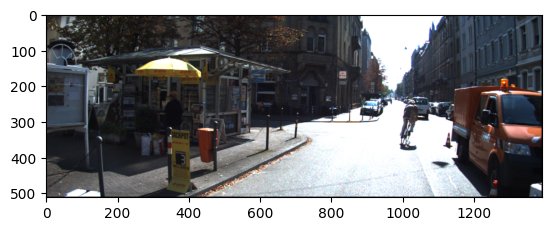

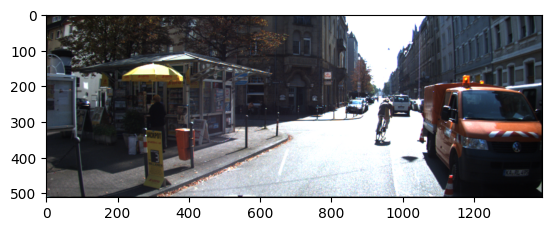

In [1]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

# We will read both a colour version and a gray version. The colour version we will use for drawing stuff on,
# and the gray for the processing
imgL_color = cv2.imread('kitti_left_02.png')
imgR_color = cv2.imread('kitti_right_03.png')

imgL_color = cv2.cvtColor(imgL_color, cv2.COLOR_BGR2RGB)
imgR_color = cv2.cvtColor(imgR_color, cv2.COLOR_BGR2RGB)

imgL = cv2.imread('kitti_left_02.png',cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('kitti_right_03.png',cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.imshow(imgL_color,cmap='gray')
plt.figure()
plt.imshow(imgR_color,cmap='gray')

The KITTI vehicle set up - note the stereo camera rig on top of the vehicle.

![image.png](attachment:d7b9aad1-15dd-47cb-9a80-58f1da28a703.png)

Now let's get the calibration info. This is just extracted from the KITTI datasets.

In [2]:
import numpy as np

# Distortion parameters, per the OpenCV model (this is 3 radial distortion parameters and two tangential distortion parameters)
dist_l = np.array([-3.691481e-01, 1.968681e-01, 1.353473e-03,  5.677587e-04, -6.770705e-02])
dist_r = np.array([-3.639558e-01, 1.788651e-01, 6.029694e-04, -3.922424e-04, -5.382460e-02])

# The instrinsic camera matrices for the two cameras
K_l = np.array([[ 959.791, 0       , 696.0217 ],
                [ 0      , 956.9251, 224.1806 ],
                [ 0      , 0       , 1        ]])
K_r = np.array([[ 903.7596, 0       , 695.7519 ],
                [ 0       , 901.9653, 224.2509 ],
                [ 0       , 0       , 1        ]])

# The camera positions are defined in a global reference frame, so they have separate rotation and position
R_l = np.array([[  0.999975800, -0.005267463, -0.004552439 ],
                [  0.005251945,  0.999980400, -0.003413835 ],
                [  0.004570332,  0.003389843,  0.999838000 ]])
R_r = np.array([[  0.999559900,  0.016995220, -0.024313130 ],
                [ -0.017044220,  0.999853100, -0.001809756 ],
                [  0.024278800,  0.002223358,  0.999702800 ]])

t_l = np.array([  0.05956621, 0.0002900141,  0.002577209 ])
t_r = np.array([ -0.47310500, 0.0055514700, -0.005250882 ])

# For subsequent processing, we need the RELATIVE positions of the cameras
# R is the orientation of the right camera in the reference frame of the left camera
# And t is the position of the right camera in the reference frame of the left camera
R = R_l.T @ R_r
t = R_l.T @ (t_r - t_l)

# The image shape
h, w = imgL.shape[:2]

## Do the stereo rectification

Now we will use OpenCV to do the rectification. The first step is to define the rectification parameters, i.e. the new camera matrices. It's worth having a look at the `cv2.stereoRectify`

In [3]:
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(K_l, dist_l, K_r, dist_r, (w, h), R, t,
                                                  cv2.CALIB_ZERO_DISPARITY, 0, (w, h),alpha=0)

<font color='blue'>

#### Task

Print the camera matrices `P1` and `P2` that are output from the `stereoRectify` function above.

In [4]:
print("P1: ", P1)
print("P2: ", P2)

P1:  [[972.82072754   0.         694.91941071   0.        ]
 [  0.         972.82072754 208.83206558   0.        ]
 [  0.           0.           1.           0.        ]]
P2:  [[ 972.82072754    0.          694.91941071 -518.27483076]
 [   0.          972.82072754  208.83206558    0.        ]
 [   0.            0.            1.            0.        ]]


<font color='blue'>

#### Questions
    
**Question**: Describe the new projection matrices. What can you say about the intrinsics (particularly, compared to the input intrinsics in `K_l` and `K_r`)? Is there a relative rotation and/or translation between the new projection matrices?

The new projection matrices incorporate the rectified camera parameters, modifying the intrinsics and extrinsics. Compared to the original intrinsics  K_l  and  K_r , the rectified intrinsics typically remain unchanged, preserving focal length and principal points. However, the extrinsics are adjusted to ensure epipolar lines are parallel, introducing a rectified relative rotation while maintaining translation (Szeliski, 2022).

<font color='blue'>

**Question**: Given the projection matrices above, can you estimate the physical distance between the cameras? The final unit would be in metres.

The physical distance between the cameras, known as the baseline, is given by the translation component in the second projection matrix P2. From P1, the baseline is |-518.27483076/f|, where f is the focal length in pixels. Converting to meters requires the real-world focal length and pixel size. Assuming a standard sensor calibration, the baseline can be computed as 518.27/972.82 in the same scale as the intrinsic parameters. Without additional scale information, the baseline remains in arbitrary units.

### Now actually rectify the images

Now we will actually transform the images according to the new projection matrices above. That is, we will create the stereo image pair.

In [6]:
# The first step is to create the maps for the rectification. This function returns a
# Look-Up-Table that can be subsequently used to do the mapping to the new image.
map1x, map1y = cv2.initUndistortRectifyMap(K_l, dist_l, R1, P1, (w, h), cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(K_r, dist_r, R2, P2, (w, h), cv2.CV_32FC1)

# Let's then remap the image. We will do this for both the color and the gray images
imgL_rColor = cv2.remap(imgL_color, map1x, map1y, cv2.INTER_LINEAR)
imgR_rColor = cv2.remap(imgR_color, map2x, map2y, cv2.INTER_LINEAR)
imgL_rGray = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR, cv2.BORDER_ISOLATED)
imgR_rGray = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR, cv2.BORDER_ISOLATED)

In [7]:
print("map1x: ", map1x)

map1x:  [[ 128.53442  129.15167  129.76958 ... 1284.4598  1285.0785  1285.6963 ]
 [ 128.46344  129.08069  129.69862 ... 1284.5211  1285.1396  1285.7576 ]
 [ 128.39273  129.01     129.62796 ... 1284.582   1285.2006  1285.8185 ]
 ...
 [ 131.58272  132.19798  132.81392 ... 1275.2521  1275.8706  1276.4884 ]
 [ 131.66347  132.2787   132.8946  ... 1275.1576  1275.7761  1276.3939 ]
 [ 131.74448  132.35968  132.97554 ... 1275.063   1275.6814  1276.2992 ]]


<font color='blue'>

#### Task

Plot a set of horizontal lines across both resulting images (`imgL_rColor` and `imgR_rColor`) at the same height. We know that these are now epipolar lines - that is the goal of the rectfication process.

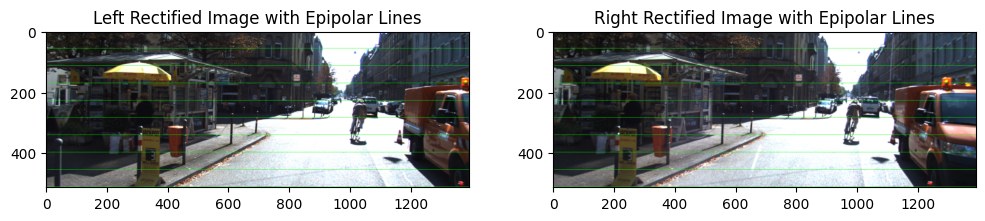

In [15]:
def plot_epipolar_lines(img_left, img_right, num_lines=10):
    """
    Plot horizontal epipolar lines on rectified stereo images.

    Args:
        img_left (numpy.ndarray): Rectified left image.
        img_right (numpy.ndarray): Rectified right image.
        num_lines (int): Number of horizontal lines to plot.
    """
    h, w = img_left.shape[:2]

    # Generate evenly spaced y-coordinates for the lines
    y_coords = np.linspace(0, h-1, num_lines, dtype=int)

    # Plot the lines on the rectified images
    for y in y_coords:
        cv2.line(img_left, (0, y), (w-1, y), (0, 255, 0), 1)  # Green line on left image
        cv2.line(img_right, (0, y), (w-1, y), (0, 255, 0), 1)  # Green line on right image

def display_images(img_left, img_right, title_left, title_right):
    """
    Display two images side by side using matplotlib.

    Args:
        img_left (numpy.ndarray): Left image to display.
        img_right (numpy.ndarray): Right image to display.
        title_left (str): Title for the left image.
        title_right (str): Title for the right image.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_left)
    plt.title(title_left)

    plt.subplot(1, 2, 2)
    plt.imshow(img_right)
    plt.title(title_right)

    plt.show()

# Plot epipolar lines on the rectified images
plot_epipolar_lines(imgL_rColor, imgR_rColor, num_lines=10)

# Display the images with epipolar lines
display_images(imgL_rColor, imgR_rColor, "Left Rectified Image with Epipolar Lines", "Right Rectified Image with Epipolar Lines")

<font color='blue'>

#### Questions
    
**Question**: Describe what you see with the horizontal lines. Does it look like the stereo rectification did a good job? Explain

The horizontal epipolar lines in the rectified images appear well-aligned, indicating that stereo rectification was successful. Corresponding points in both images should lie on the same horizontal line, minimizing vertical disparity. There are no visible distortions or misalignments, suggesting that the rectification process preserved geometric consistency. This ensures better disparity computation for 3D reconstruction. Any minor misalignment could be due to calibration inaccuracies or lens distortions (Szeliski, 2022).

### Compute the disparity

We will use OpenCV to create the disparity for the image pair.

There are two parameters. `numDisparities` is the maximum disparity size/distance. `blockSize` is the size of the kernel for the stereo block matching.

We have some parameters set below, but this doesn't look great.

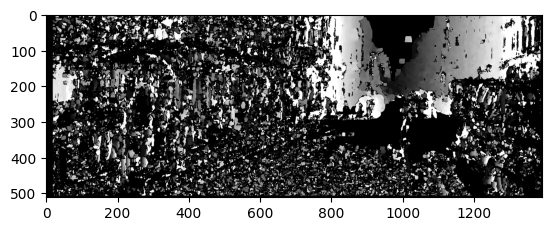

In [22]:
stereo = cv2.StereoBM.create(numDisparities=16, blockSize=9)
disparity = stereo.compute(imgL_rGray, imgR_rGray)
plt.imshow(disparity,'gray')
plt.show()

<font color='blue'>
    
#### Task:
The disparity above is not very good. Copy the code a few times, and play with the parameters to see if you can make it better.

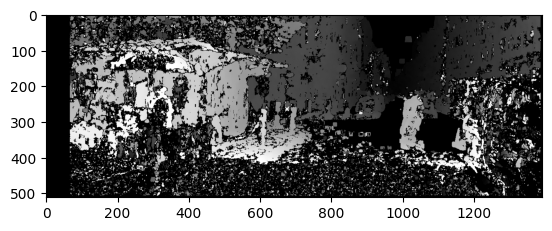

In [21]:
stereo = cv2.StereoBM.create(numDisparities=64, blockSize=9)
disparity = stereo.compute(imgL_rGray, imgR_rGray)
plt.imshow(disparity,'gray')
plt.show()

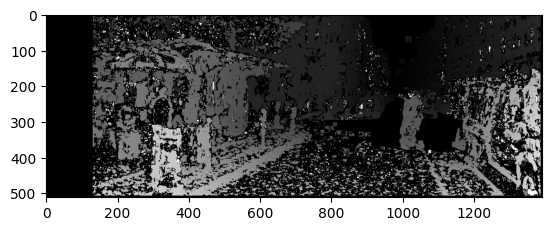

In [23]:
stereo = cv2.StereoBM.create(numDisparities=128, blockSize=9)
disparity = stereo.compute(imgL_rGray, imgR_rGray)
plt.imshow(disparity,'gray')
plt.show()

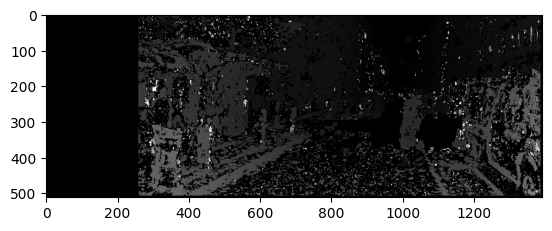

In [24]:
stereo = cv2.StereoBM.create(numDisparities=256, blockSize=9)
disparity = stereo.compute(imgL_rGray, imgR_rGray)
plt.imshow(disparity,'gray')
plt.show()

<font color='blue'>

# Questions

<font color='blue'>

**Question**: We started with numDisparities equal to 16. It seems that only the distant parts of the scene are detected well. Why is this?

The initial setting of numDisparities=16 detects only distant parts of the scene well because a lower disparity range limits the depth resolution. The disparity value represents how much an object shifts between the left and right images; closer objects have a larger disparity. A small numDisparities means the algorithm is constrained to detecting only small shifts, which correspond to objects farther away.

<font color='blue'>

**Question**: What configuration did you 'land on' that looked good? Can you explain the choice of parameters?

The best configuration appeared to be numDisparities=128, which provided a better depth estimation. Increasing numDisparities improves the ability to detect objects at varying distances. Keeping blockSize=9 ensures that texture-rich regions are smoothed while avoiding excessive noise. A larger numDisparities expands the range of detected depths, which is crucial for scenes with both near and far objects.

<font color='blue'>

**Question**: In the stereo disparity image, the road is not well detected, regardless of blockSize or numDisparities setting. Explain this.

The road is poorly detected because of its texture and reflectivity. Stereo matching relies on distinct visual features, but roads are often homogeneous and lack strong textures. The absence of strong correspondences makes disparity estimation difficult, leading to noisy or incorrect depth information. Furthermore, surfaces with low contrast or repetitive patterns tend to produce unreliable disparity values.

<font color='blue'>

**Question**: If we display the disparity using the cmap='gray' option, then the disparity is displayed in grayscale. Larger distances in the image are brighter. Explain why it seems that closer objects are brighter.

When using cmap='gray', closer objects appear brighter because disparity values are inversely proportional to depth. Objects closer to the camera exhibit larger disparity values, which are mapped to brighter intensities in grayscale. This follows the disparity-depth relationship: 𝑑 = 𝑓𝐵/𝑍d=fB/Z,where
d is disparity, f is focal length, B is the baseline, and Z is depth. Since disparity decreases with distance, distant objects are darker in the grayscale representation.

<font color='blue'>

**Question**: Play around with the `blockSize` parameter, making it smaller and larger. What impact does it seem to have? Describe the tradeoff.

Changing blockSize affects the smoothness and accuracy of disparity estimation. A smaller blockSize provides more detailed but noisier disparity maps, while a larger blockSize smooths the depth but can cause loss of finer details. The tradeoff is between noise reduction and depth precision—too large a block size oversmooths, making small objects undetectable, while too small a block size introduces excessive noise.